In [ ]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pré-processamento

In [ ]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Input, concatenate, Flatten
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage.filters import rank
from skimage.morphology import disk
import copy
import tqdm
import pandas as pd

In [ ]:
import nibabel as nib
import os

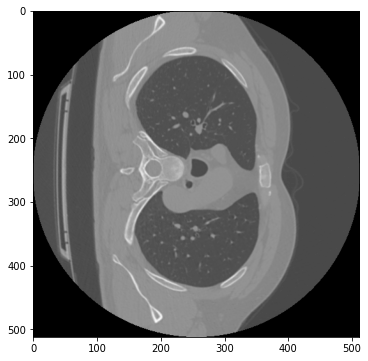

In [ ]:
test = nib.load('/content/drive/MyDrive/base_pibic/originais_fatiados/paciente001/slice (30).nii')
test = np.array(test.dataobj)
test = test.reshape((512, 512))
plt.figure(figsize=(6, 6))
#plt.savefig("/content/drive/MyDrive/base_pibic/Results/test1.png")
plt.imshow(test, cmap='gray')

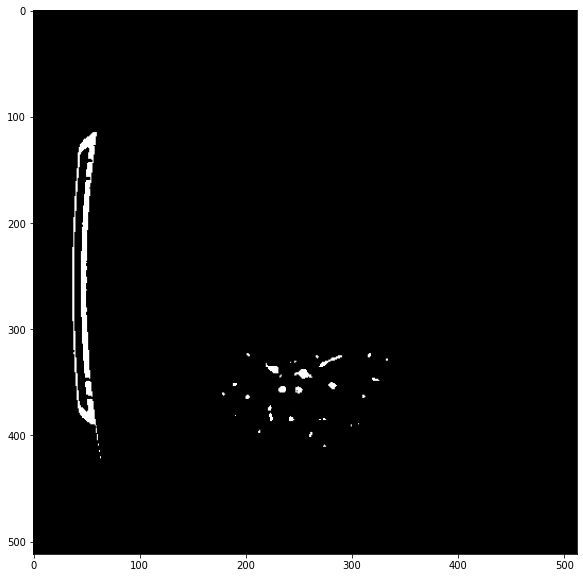

In [ ]:
test = nib.load('/content/drive/MyDrive/base_pibic/vessels_fatiados/paciente001/slice (30)_vessel_only_mask.nii.gz')
test = np.array(test.dataobj)
test = test.reshape((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(test, cmap='gray')

## Modelo 3D

In [ ]:
# ler dados e formar base em 3D

X = []
y = []
patients = os.listdir('/content/drive/MyDrive/base_pibic/vessels_fatiados/')
for patient in tqdm.tqdm(patients[:30]):
  x_slices = []
  y_slices = []
  for i in range(40):
    x_path = f'/content/drive/MyDrive/base_pibic/originais_fatiados/{patient}/slice ({i+1}).nii'
    y_path = f'/content/drive/MyDrive/base_pibic/vessels_fatiados/{patient}/slice ({i+1})_vessel_only_mask.nii.gz'
    
    if os.path.isfile(x_path):
      a = nib.load(x_path)
      a = np.array(a.dataobj)
      a = a.reshape((512, 512))
    else:
      a = np.zeros((512, 512), dtype=np.uint8)

    x_slices.append(a)

    if os.path.isfile(y_path):
      a = nib.load(y_path)
      a = np.array(a.dataobj)
      a = a.reshape((512, 512))
    else:
      a = np.zeros((512, 512), dtype=np.uint8)

    y_slices.append(a)

  X.append(np.stack(x_slices, axis=-1))
  y.append(np.stack(y_slices, axis=-1))



100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


In [ ]:
np.save('/content/drive/MyDrive/base_pibic/X.npy', X)
np.save('/content/drive/MyDrive/base_pibic/y.npy', y)

In [ ]:
X[0].shape

(512, 512, 40)

In [ ]:
from __future__ import print_function

import os
import keras.models as models
from skimage.transform import resize
from skimage.io import imsave
import numpy as np

np.random.seed(256)
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2

# from data3D import load_train_data, load_test_data, preprocess_squeeze

In [ ]:
project_name = '3D-Unet'
img_rows = 400
img_cols = 400
img_depth = 16
smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet_3D():
    inputs = Input((32, 512, 512, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = get_unet_3D()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 512, 512 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 512, 512, 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 512, 512, 27680       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 16, 256, 256, 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
X = np.load('/content/drive/MyDrive/base_pibic/X.npy')


AttributeError: ignored

In [ ]:
y = np.load('/content/drive/MyDrive/base_pibic/y.npy')

In [ ]:
X.shape

(30, 512, 512, 52)

In [ ]:
X = (np.array(X)[:, :, :, :32]).reshape((30, 32, 512, 512))
y = (np.array(y)[:, :, :, :32]).reshape((30, 32, 512, 512))

In [ ]:
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/base_pibic/model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model.fit(X, y, batch_size=1, epochs=50, verbose=1, shuffle=True, validation_split=0.10, callbacks=[model_checkpoint])

Epoch 1/50
27/27 [==============================] - 196s 6s/step - loss: -43.8805 - accuracy: 0.1750 - val_loss: -33.4223 - val_accuracy: 0.0000e+00
Epoch 2/50
27/27 [==============================] - 149s 6s/step - loss: -103.5482 - accuracy: 0.0000e+00 - val_loss: -33.4223 - val_accuracy: 0.0000e+00
Epoch 3/50
27/27 [==============================] - 149s 6s/step - loss: -115.0989 - accuracy: 0.0000e+00 - val_loss: -33.4223 - val_accuracy: 0.0000e+00
Epoch 4/50
27/27 [==============================] - 149s 6s/step - loss: -141.0301 - accuracy: 0.0000e+00 - val_loss: -33.4223 - val_accuracy: 0.0000e+00
Epoch 5/50
27/27 [==============================] - 149s 6s/step - loss: -112.6286 - accuracy: 0.0000e+00 - val_loss: -33.4223 - val_accuracy: 0.0000e+00
Epoch 6/50
 1/27 [>.............................] - ETA: 2:18 - loss: -386.5371 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

## Modelo 2D

In [ ]:
!pip install tensorflow==2.4.1 
!pip install keras==2.4.3
!pip install focal_loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 2.9 MB 34.6 MB/s 
     |████████████████████████████████| 132 kB 57.8 MB/s 
     |████████████████████████████████| 14.8 MB 38.7 MB/s 
     |████████████████████████████████| 3.8 MB 41.5 MB/s 
     |████████████████████████████████| 462 kB 47.1 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68723 sha256=5cd81426f93596b8bb18e89a65c68fa15ba41ebba0d1facb7321ac242f6db9cc
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2 as cv
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, save_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from focal_loss import BinaryFocalLoss

sns.set(style='white', context='notebook', palette='deep')

from glob import glob    
from skimage.util import montage 
from skimage.io   import imread
%matplotlib inline

In [ ]:
import os
import tqdm
import nibabel as nib

In [ ]:
# ler dados e formar base em 2D

x_slices = []
y_slices = []
patients = os.listdir('/content/drive/MyDrive/base_pibic/vessels_fatiados/')
for patient in tqdm.tqdm(patients[:30]):
  for i in range(52):
    x_path = f'/content/drive/MyDrive/base_pibic/originais_fatiados/{patient}/slice ({i+1}).nii'
    y_path = f'/content/drive/MyDrive/base_pibic/vessels_fatiados/{patient}/slice ({i+1})_vessel_only_mask.nii.gz'
    
    if os.path.isfile(x_path) and os.path.isfile(y_path):
      a = nib.load(x_path)
      a = np.array(a.dataobj)
      a = a.reshape((512, 512))

      b = nib.load(y_path)
      b = np.array(b.dataobj)
      b = b.reshape((512, 512))
    else:
      # np.ones((512, 512), dtype=np.uint8)
      a = np.ones((512, 512), dtype=np.uint8)
      b = np.ones((512, 512), dtype=np.uint8)

    x_slices.append(a)
    y_slices.append(b)


100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


In [ ]:
np.save('/content/drive/MyDrive/base_pibic/X_2D.npy', x_slices)
np.save('/content/drive/MyDrive/base_pibic/y_2D.npy', y_slices)

In [ ]:
def get_unet_2D(inputs, n=32):
    bn    = BatchNormalization()(inputs)  
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bn)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    
    pool4 = Dropout(0.1)(pool4)

    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

    up6   = Conv2DTranspose(n*8, (2, 2), strides=(2, 2), padding='same')(convm)
    conv6 = concatenate([up6, conv4])
    conv6 = Dropout(0.1)(conv6)                   
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7   = Conv2DTranspose(n*4, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = concatenate([up7, conv3])
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8   = Conv2DTranspose(n*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    conv8 = concatenate([up8, conv2])
    conv8 = Dropout(0.1)(conv8)  
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9   = Conv2DTranspose(n, (2, 2), strides=(2, 2), padding='same')(conv8)
    conv9 = concatenate([up9, conv1])
    conv9 = Dropout(0.1)(conv9) 
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[output])

In [ ]:
X_train = np.load('/content/drive/MyDrive/base_pibic/X_2D.npy')
y_train = np.load('/content/drive/MyDrive/base_pibic/y_2D.npy')

X_train = X_train[:500]
y_train = y_train[:500]

In [ ]:
X_train.shape

(500, 512, 512)

In [ ]:
input_img = Input((512,512,1), name='img')
n_filters   = 32

model = get_unet_2D(input_img, n_filters)

model.compile(optimizer=Adam(), loss=BinaryFocalLoss(gamma=2), metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 1)  4           img[0][0]                        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
input_img = Input((512,512,1), name='img')
n_filters   = 32
model = get_unet_2D(input_img, n_filters)

model.load_weights('/content/drive/MyDrive/base_pibic/model_2D.h5')

ModuleNotFoundError: ignored

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/base_pibic/model_2D.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(X_train, X_train, test_size=0.2, random_state=42)

X_train = X_train.reshape((500, 512, 512, 1))/255
#X_train = X_train.reshape((100, 512, 512, 1))/255
#y_train = y_train.reshape((400, 512, 512, 1))/255
history = model.fit(X_train, y_train, batch_size=1, epochs=10, callbacks=callbacks,
                    validation_split=0.2,
                     shuffle=True)

Epoch 1/10
400/400 [==============================] - 82s 159ms/step - loss: 0.1114 - accuracy: 0.8899 - val_loss: 0.2970 - val_accuracy: 0.7473

Epoch 00001: val_loss improved from inf to 0.29696, saving model to /content/drive/MyDrive/base_pibic/model_2D.h5
Epoch 2/10
400/400 [==============================] - 66s 164ms/step - loss: 0.0598 - accuracy: 0.9531 - val_loss: 0.2304 - val_accuracy: 0.7473

Epoch 00002: val_loss improved from 0.29696 to 0.23045, saving model to /content/drive/MyDrive/base_pibic/model_2D.h5
Epoch 3/10
400/400 [==============================] - 67s 169ms/step - loss: 0.0458 - accuracy: 0.9632 - val_loss: 0.3279 - val_accuracy: 0.7473

Epoch 00003: val_loss did not improve from 0.23045
Epoch 4/10
400/400 [==============================] - 67s 168ms/step - loss: 0.0459 - accuracy: 0.9629 - val_loss: 0.2922 - val_accuracy: 0.7473

Epoch 00004: val_loss did not improve from 0.23045
Epoch 5/10
400/400 [==============================] - 67s 167ms/step - loss: 0.080

In [ ]:
import cv2
from tqdm import tqdm
for i in tqdm(range(500)):
    result = model.predict(X_train[i].reshape((1,512,512,1))) 
    result = result.reshape((512,512))
    ret,thresh = cv2.threshold(result*255,100,255,cv2.THRESH_BINARY)

    plt.imsave(f'/content/drive/MyDrive/base_pibic/Results_test/paciente{i}.png', thresh)

100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


In [ ]:
plt.imshow(result, cmap='gray')

In [ ]:
# Threshold manual
import cv2

result_test = result.copy()*255

thrs = 100
for i in range(result_test.shape[0]):
  for j in range(result_test.shape[1]):
    if result_test[i,j] <= thrs:
      result_test[i,j] = 0.0

plt.figure(figsize=((15,15)))
plt.imshow(result_test, cmap='gray')
 

In [ ]:
df = pd.DataFrame(history.history)
df.to_csv('/content/drive/MyDrive/base_pibic/model_2D.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/base_pibic/model_2D.csv')

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.imshow()
    plt.savefig('/content/drive/MyDrive/base_pibic/plots/plot.png')

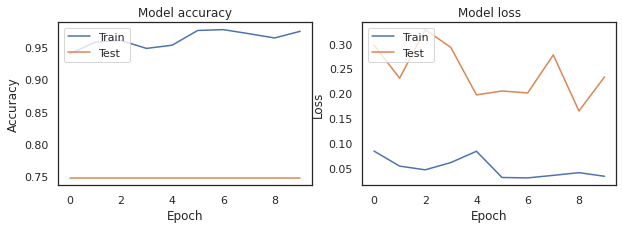

In [ ]:
plot_history(history, 'UNet Loss/Accuracy')

In [ ]:
X_train.shape

(500, 512, 512, 1)

In [ ]:
y_pred = []
for i in range(500):
    pred = model.predict(X_train[i].reshape(1,512,512,1))
    y_pred.append(pred.reshape(512,512))

In [20]:
#load images
#y_pred = cv2.imread('predictions/image_001.png')
#y_true = cv2.imread('ground_truth/image_001.png') 

# Dice similarity function
def dice(pred, true, k = 1):
    #print(pred)
    #print()
    #print(true)
    ret,thresh1 = cv2.threshold(pred*255,100,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(true*255,100,255,cv2.THRESH_BINARY)
    
    pred = thresh1
    true = thresh2

    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

#dice_score = []
#dice_score = dice(y_pred, y_true, k = 255) #255 in my case, can be 1 
#print ("Dice Similarity: {}".format(dice_score))

In [23]:
from tqdm import tqdm
import numpy as np 
import cv2

#X_train = np.load('/content/drive/MyDrive/base_pibic/X_2D.npy')
#y_train = np.load('/content/drive/MyDrive/base_pibic/y_2D.npy')

#X_train = X_train[:500]
#y_train = y_train[:500]

dice_result = []
for i in tqdm(range(500)):

    y_pred = cv2.imread(f'/content/drive/MyDrive/base_pibic/Results/paciente{i}.png', cv2.IMREAD_GRAYSCALE)
    try:
        dice_result.append(dice(y_pred, X_train[i], k = 255))
    except:
        pass
    #break

100%|██████████| 500/500 [00:04<00:00, 124.06it/s]


In [38]:

print()
print(np.mean(dice_result))
print(np.std(dice_result))
print(dice_result)


0.8867870691200664
0.06568335071461907
[0.769945188433979, 0.7750806242790895, 0.7849164753680647, 0.785292343094473, 0.7853090698207362, 0.7853146787615264, 0.7864108077786088, 0.7866736283664403, 0.7870687221977294, 0.7889757090311619, 0.7890715173447808, 0.7894898829981207, 0.7895552740752791, 0.7901678099085097, 0.7909821115316609, 0.791196388261851, 0.7915002448460488, 0.7926344803804385, 0.793663456342921, 0.7941430880507958, 0.7957165934559324, 0.7967811218396763, 0.7971537999921222, 0.7971812040206441, 0.7977069339599753, 0.7988092685210165, 0.8002901120154726, 0.8012670405651389, 0.8013007710661348, 0.8021863120064814, 0.8024998218026217, 0.803467834013618, 0.8048277811093419, 0.8056752881803062, 0.8060290711952792, 0.8062355695265085, 0.8064796689943846, 0.8067313648564939, 0.8083683808286006, 0.8108205714285714, 0.8111649102819709, 0.8115721581202437, 0.8116340768399332, 0.8126137440487744, 0.812636309865009, 0.8129682193609135, 0.8130449339772785, 0.8130600684831706, 0.814

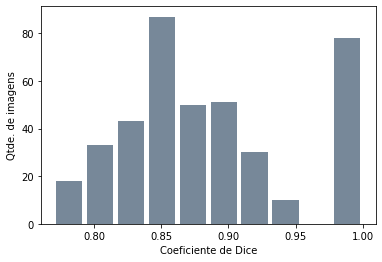

In [39]:
import matplotlib.pyplot as plt
dice2 = [0.8328884573131576, 0.8013007710661348, 0.8589626373626373, 0.8470673268679443, 0.8920416984490211, 0.8588597449267192, 0.907843518675393, 0.8195562617034557, 0.9198241869476025, 0.8573282419321604, 0.7866736283664403, 0.8868846683534574, 0.862958157283801, 0.8470234076697472, 0.880219879947623, 0.9268924610489244, 0.8392756715258746, 0.8538938070649839, 0.9043606395183614, 0.9329734260217917, 0.8986167444506484, 0.859017267876154, 0.9101780422237655, 0.8414965909984388, 0.8201988046470418, 0.880089769611356, 0.8937140094815669, 0.785292343094473, 0.8259344902678311, 0.7988092685210165, 0.854687682840937, 0.8443852362667502, 0.848277784592054, 0.8475083668860083, 0.8840383687905257, 0.8376144739781104, 0.8695145007978908, 0.886447354957536, 0.8382062598969038, 0.8562281594683799, 0.7890715173447808, 0.8468987431655187, 0.8895602208156895, 0.7967811218396763, 0.840966484801247, 0.83447365531275, 0.8274848645153706, 0.8464373981757528, 0.8386342292384061, 0.8540344834420897, 0.8256794013391099, 0.88229485935569, 0.8395044540304091, 0.890697902330318, 0.8002901120154726, 0.9257717098082824, 0.8692728622786827, 0.8267771374220435, 0.819619714956291, 0.8316812089592516, 0.89311342359226, 0.9211837482594684, 0.9227719907407408, 0.8557905324121248, 0.8620861475919019, 0.8985936030600492, 0.8966377513850533, 0.7926344803804385, 0.9242194817036692, 0.8614160902963123, 0.8178635722609929, 0.9126022695082732, 0.8658664597690657, 0.8634553331308863, 0.8116340768399332, 0.8597073961217027, 0.8339000013403448, 0.7894898829981207, 0.8083683808286006, 0.8264632954463187, 0.8504740290478277, 0.8508579438134822, 0.8646218839466517, 0.9263892403175407, 0.852098253246383, 0.8764848265584757, 0.8524046802412002, 0.870426473507081, 0.8866164679903198, 0.8745120944537721, 0.8554701825041119, 0.853290769244355, 0.7889757090311619, 0.8606463807783896, 0.9418629297202997, 0.8291541772779518, 0.855508195280573, 0.9248946750252346, 0.8933901062058841, 0.8942204455082096, 0.8388390440182071, 0.8605100276701229, 0.8130600684831706, 0.8879672478270522, 0.8785306971367673, 0.8615553217604769, 0.7957165934559324, 0.8742049974988685, 0.8584618213338236, 0.8722216799522803, 0.9128254368080538, 0.8141546036030481, 0.816060346648077, 0.8067313648564939, 0.922293757169283, 0.8908821229430165, 0.999980926149867, 0.8746641261867902, 0.7864108077786088, 0.861404493277988, 0.856915417634227, 0.8311957987621352, 0.8419890236345933, 0.8111649102819709, 0.9214669433027117, 0.8549150458796154, 0.8489148211996641, 0.81811280960368, 0.8517443655449213, 0.8981558017130922, 0.8805296341377024, 0.8312762377950033, 0.8712055225491089, 0.8354002407259646, 0.8021863120064814, 0.8158081285444234, 0.7750806242790895, 0.8950080515297907, 0.8062355695265085, 0.8160209603007348, 0.7971812040206441, 0.8887061848404993, 0.8024998218026217, 0.936635497998049, 0.8940957579815977, 0.8845832458444569, 0.8546590671981902, 0.8129682193609135, 0.8618187398605691, 0.8687178330941365, 0.7853090698207362, 0.9231109869530579, 0.877553575437324, 0.8471240054165523, 0.8012670405651389, 0.85577835145705, 0.883428216096834, 0.8160152136814204, 0.9039648136008965, 0.769945188433979, 0.8356030186401706, 0.8932396813226258, 0.8060290711952792, 0.8852934665569127, 0.8960835242755179, 0.9254782922926024, 0.8500233354760878, 0.8048277811093419, 0.8362196402651523, 0.8669508141193636, 0.8569501682732441, 0.8530066962367546, 0.8906621962868333, 0.8592349395339842, 0.8817509790247304, 0.8613490983662051, 0.8189345908260193, 0.9015887034875774, 0.8809138067175724, 0.8942817187735415, 0.869922558951889, 0.8207392262144398, 0.8589382562679841, 0.9080451813862757, 0.8586918373352808, 0.8749202338796727, 0.7870687221977294, 0.8703819716160471, 0.8682774406542596, 0.7895552740752791, 0.8613583576589108, 0.8640138393188679, 0.8463422303117264, 0.8987263724179431, 0.8598706579270217, 0.8584655243840157, 0.8442328390603179, 0.8770603076351974, 0.8536794260993373, 0.8491724848447332, 0.8936574443181625, 0.8687571683480441, 0.8727298628528507, 0.8931511025302307, 0.8406801543930748, 0.8397661762464473, 0.9163830206486004, 0.791196388261851, 0.8838893276560675, 0.8684509136440114, 0.8577698759830281, 0.8336466186370194, 0.9192399543141937, 0.885099789344278, 0.8813335994351774, 0.8883835214278877, 0.8771917718120515, 0.8130449339772785, 0.8299566335376316, 0.8863439921632736, 0.9408505890553776, 0.8776663227524054, 0.83641592052807, 0.8481379795535045, 0.838849905411026, 0.8943809151615041, 0.8399762019689503, 0.940530080514185, 0.9414843615174556, 0.8452413952157821, 0.8531786241746306, 0.8997831278533033, 0.7901678099085097, 0.812636309865009, 0.8482231772573771, 0.9372532689944602, 0.8616340601190084, 0.8990544511522561, 0.8421282357342645, 0.8350104873314377, 0.7941430880507958, 0.8115721581202437, 0.793663456342921, 0.8177538301208027, 0.8208119826566811, 0.9235194781543352, 0.7853146787615264, 0.8388560850133364, 0.8489291138455817, 0.8557048598171815, 0.8356943734557637, 0.9409564085881588, 0.7971537999921222, 0.8922510855618154, 0.8871335978383555, 0.8516354702183642, 0.8898600581852159, 0.8504268118777732, 0.8872897780021477, 0.8056752881803062, 0.879548300729801, 0.8878662619675021, 0.8635977133288856, 0.9353805919069949, 0.8064796689943846, 0.909555339797734, 0.9131472514598017, 0.9162599739827159, 0.9168903368254292, 0.8604885136548263, 0.8962676494357681, 0.8497074092702847, 0.9110807739851746, 0.8640825074250155, 0.889225479481821, 0.8835283613355197, 0.8615906315613772, 0.7915002448460488, 0.9227488935765397, 0.8625411176132903, 0.8882564128803384, 0.8936958553868525, 0.8829134325279145, 0.8983073143201463, 0.8608737489958221, 0.8420213061396785, 0.7849164753680647, 0.8964616092773249, 0.8374762627113883, 0.8486616152675, 0.8458903425325072, 0.8587037671383275, 0.8932756693469532, 0.803467834013618, 0.8494340906780747, 0.8287384300251984, 0.8433381617971646, 0.9049420517232654, 0.9336249419476537, 0.8946542480998915, 0.8573323261778449, 0.8212895182398813, 0.8711323370687847, 0.8808454757426301, 0.9118121162702464, 0.8571007835423146, 0.8152926197080624, 0.9166563108404788, 0.8583154123433647, 0.8361340786113541, 0.9080042493036328, 0.9083849148774047, 0.7909821115316609, 0.8126137440487744, 0.8667419586039138, 0.8465097735201285, 0.7977069339599753, 0.8246870498488507, 0.9234747835283231, 0.8645457712742792, 0.8538777917393783, 0.8108205714285714, 0.8531126583421622]
dice3 = dice_result
dice3.sort()
plt.hist(dice3,color='lightslategrey', rwidth=0.85)
plt.xlabel('Coeficiente de Dice')
plt.ylabel('Qtde. de imagens')#plt.show()
plt.savefig('/content/drive/MyDrive/base_pibic/plots/dice_histogram.png')